In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data 

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta

from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

## Generating the data and preparing the dataloader

In [2]:
n_train, n_test = 2000, 1000
train_data, train_labels = make_moons(n_samples=n_train, noise=0.07)
test_data, test_labels = make_moons(n_samples=n_test, noise=0.07)

train_data = np.float32(train_data)
test_data = np.float32(test_data)

train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=256, shuffle=True)## Visualizing the data

## Visualizing the data

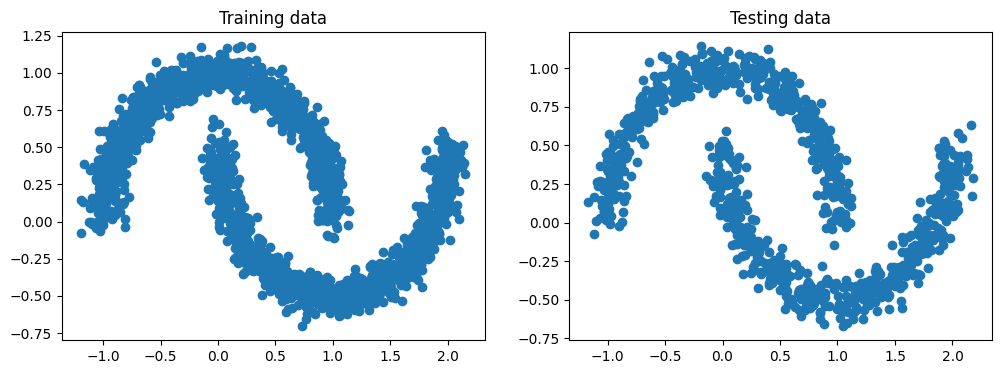

In [3]:
_, axes = plt.subplots(1,2,figsize=(12,4))
x,y = train_loader.dataset[:,0], train_loader.dataset[:,1]
_ = axes[0].scatter(x,y)
_ = axes[0].set_title('Training data')

x,y = test_loader.dataset[:,0], test_loader.dataset[:,1]
_ = axes[1].scatter(x,y)
_ = axes[1].set_title('Testing data')

## RealNVP model

In [4]:
class BatchNorm(nn.Module):
    def __init__(self, input_size, momentum=0.9, eps=1e-5):
        super().__init__()
        self.register_buffer('running_mean', torch.zeros(input_size))
        self.register_buffer('running_var', torch.ones(input_size))
    
        self.momentum = momentum
        self.eps = eps
    
        self.log_gamma = nn.Parameter(torch.zeros(input_size))
        self.beta = nn.Parameter(torch.zeros(input_size))
  
    def forward(self, x):
        if self.training:
            self.batch_mean = x.mean(0)
            self.batch_var = x.var(0)
    
            self.running_mean = self.running_mean * self.momentum + self.batch_mean * (1 - self.momentum)
            self.running_var = self.running_var * self.momentum + self.batch_var * (1 - self.momentum)
    
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var
    
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        y = self.log_gamma.exp() * x_hat + self.beta
    
        log_det = self.log_gamma - 0.5 * torch.log(var + self.eps)
    
        return y, log_det
    
    def inverse(self, x):
        if self.training:
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - self.beta) * torch.exp(-self.log_gamma)
        x = x_hat * torch.sqrt(var + self.eps) + mean

        log_det = 0.5 * torch.log(var + self.eps) - self.log_gamma

        return x, log_det.expand_as(x).sum(1)


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
        super().__init__()
        layers = [nn.Linear(input_size, hidden_size)]
        for _ in range(num_hidden_layers - 1):
            layers.append( nn.Linear(hidden_size, hidden_size) )
            layers.append( nn.ReLU() )
        layers.append( nn.Linear(hidden_size, output_size) )
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class CouplingLayer2D(nn.Module):
    def __init__(self, flag, hidden_size, num_hidden_layers):
        super().__init__()
        self.mlp = MLP(2, hidden_size, num_hidden_layers, 2)
        self.mask = torch.FloatTensor([1,0]) if flag else torch.FloatTensor([0,1])
        self.mask = self.mask.view(1,-1)

    def forward(self, x):
        x_masked = x * self.mask
        log_scale, shift = self.mlp(x_masked).chunk(2, dim=1)
        log_scale = log_scale.tanh()
        shift = shift  * (1-self.mask)
        log_scale = log_scale * (1-self.mask)
        x = x * torch.exp(log_scale) + shift
        return x, log_scale
    
    def inverse(self, x):
        x_masked = x * self.mask
        log_scale, shift = self.mlp(x_masked).chunk(2, dim=1)
        log_scale = log_scale.tanh()
        shift = shift  * (1-self.mask)
        log_scale = log_scale * (1-self.mask)
        x = (x - shift) * torch.exp(-log_scale)

        return x, log_scale


class RealNVP(nn.Module):
    def __init__(self, n_flows, hidden_size, n_hidden_layers):
        super().__init__()
        flows = []
        
        for i in range(n_flows):
            flows.append(CouplingLayer2D(i%2==0, hidden_size, n_hidden_layers))
            flows.append(BatchNorm(2))
        
        self.transforms = nn.ModuleList(flows)
        
        self.register_buffer('prior_mean', torch.zeros(2))
        self.register_buffer('prior_var', torch.ones(2))
    
    def loss(self, z, log_det_jacobian):
        log_likelihood = self.log_prob(z) + log_det_jacobian
        return -log_likelihood.sum() / z.shape[0]
    
    def forward(self, x):
        z, log_det_jacobian = x, torch.zeros_like(x)
        for transform in self.transforms:
            z, scale = transform(z)
            log_det_jacobian += scale
        return z, self.loss(z, log_det_jacobian)
    
    def log_det_jacobian(self, x):
        z, log_det_jacobian = x, torch.zeros_like(x)
        for transform in self.transforms:
            z, scale = transform(z)
            log_det_jacobian += scale
        return z, log_det_jacobian

    @property
    def prior(self):
        return Normal(self.prior_mean, self.prior_var)
    
    def log_prob(self, x):
        return self.prior.log_prob(x)
    
    def sample(self, n):
        u = self.prior.sample([n])
        for transform in self.transforms[::-1]:
            u,_ = transform.inverse(u)
        return u
    
    def inverse_per_layer(self, n_samples):
        u = self.prior.sample([n_samples])
        sample_per_layer = [u]
        for n, transform in enumerate(self.transforms[::-1]):
            u, _ = transform.inverse(u)
            if n % 2 == 1:
                sample_per_layer.append(u)
        return sample_per_layer
    
    def forward_per_layer(self, x):
        z, _ = x, torch.zeros_like(x)
        data_per_layer = [x]
        
        for n, transform in enumerate(self.transforms):
            z, _ = transform(z)
            if n % 2 == 0:
                data_per_layer.append(z)
        return data_per_layer

## Training the RealNVP model

In [5]:
def train(model, train_loader, optimizer):
    model.train()
    for x in train_loader:
        z, loss = model(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    for x in data_loader:
        z, loss = model(x)
        total_loss += loss.item() /len(data_loader)
    return total_loss

def train_and_eval(model, epochs, optimizer, train_loader, test_loader):
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train(model, train_loader, optimizer)
        train_loss = eval_loss(model, train_loader)
        test_loss = eval_loss(model, test_loader)
        if epoch % 50 == 49:
            print(f'Epoch {epoch+1:3d}/{epochs} | Train Loss = {train_loss:.6f} | Test Loss = {test_loss:.6f}')
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return train_losses, test_losses

In [6]:
nf_model = RealNVP(n_flows=8, hidden_size=256, n_hidden_layers=2)

In [7]:
optimizer = torch.optim.Adam(nf_model.parameters(), lr=5e-5)

In [8]:
train_losses, test_losses = train_and_eval(nf_model, 500, optimizer, train_loader, test_loader)

Epoch  50/500 | Train Loss = 0.897508 | Test Loss = 0.906643
Epoch 100/500 | Train Loss = 0.766863 | Test Loss = 0.791131
Epoch 150/500 | Train Loss = 0.723778 | Test Loss = 0.747540
Epoch 200/500 | Train Loss = 0.723401 | Test Loss = 0.759449
Epoch 250/500 | Train Loss = 0.702793 | Test Loss = 0.733050
Epoch 300/500 | Train Loss = 0.693086 | Test Loss = 0.739669
Epoch 350/500 | Train Loss = 0.670437 | Test Loss = 0.716289
Epoch 400/500 | Train Loss = 0.698132 | Test Loss = 0.744168
Epoch 450/500 | Train Loss = 0.677603 | Test Loss = 0.731572
Epoch 500/500 | Train Loss = 0.657747 | Test Loss = 0.706245


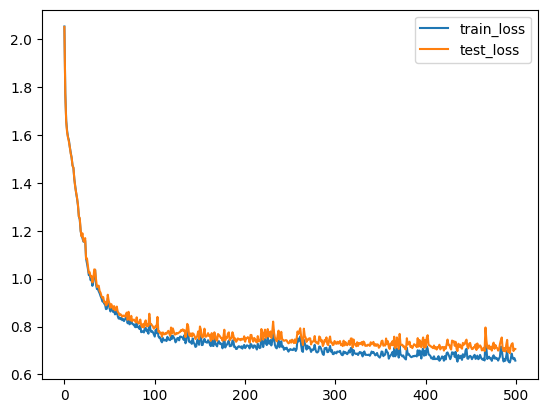

In [9]:
_ = plt.plot(train_losses, label='train_loss')
_ = plt.plot(test_losses, label='test_loss')
_ = plt.legend()

## Visualizing the results

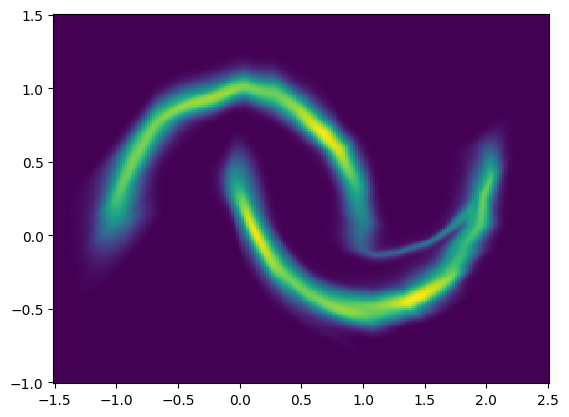

In [10]:
xs = np.linspace(-1.5,2.5,200)
ys = np.linspace(-1,1.5,200)
xs, ys = np.meshgrid(xs, ys)
x = np.stack([xs, ys], axis=2).reshape(-1,2)
with torch.no_grad():
    z, log_det_jacobian = nf_model.log_det_jacobian(torch.FloatTensor(x))
    px = (nf_model.log_prob(z) + log_det_jacobian)
    px = px.sum(1).exp()
    px = px.cpu().numpy().reshape(200,200)
    plt.pcolor(xs,ys,px)

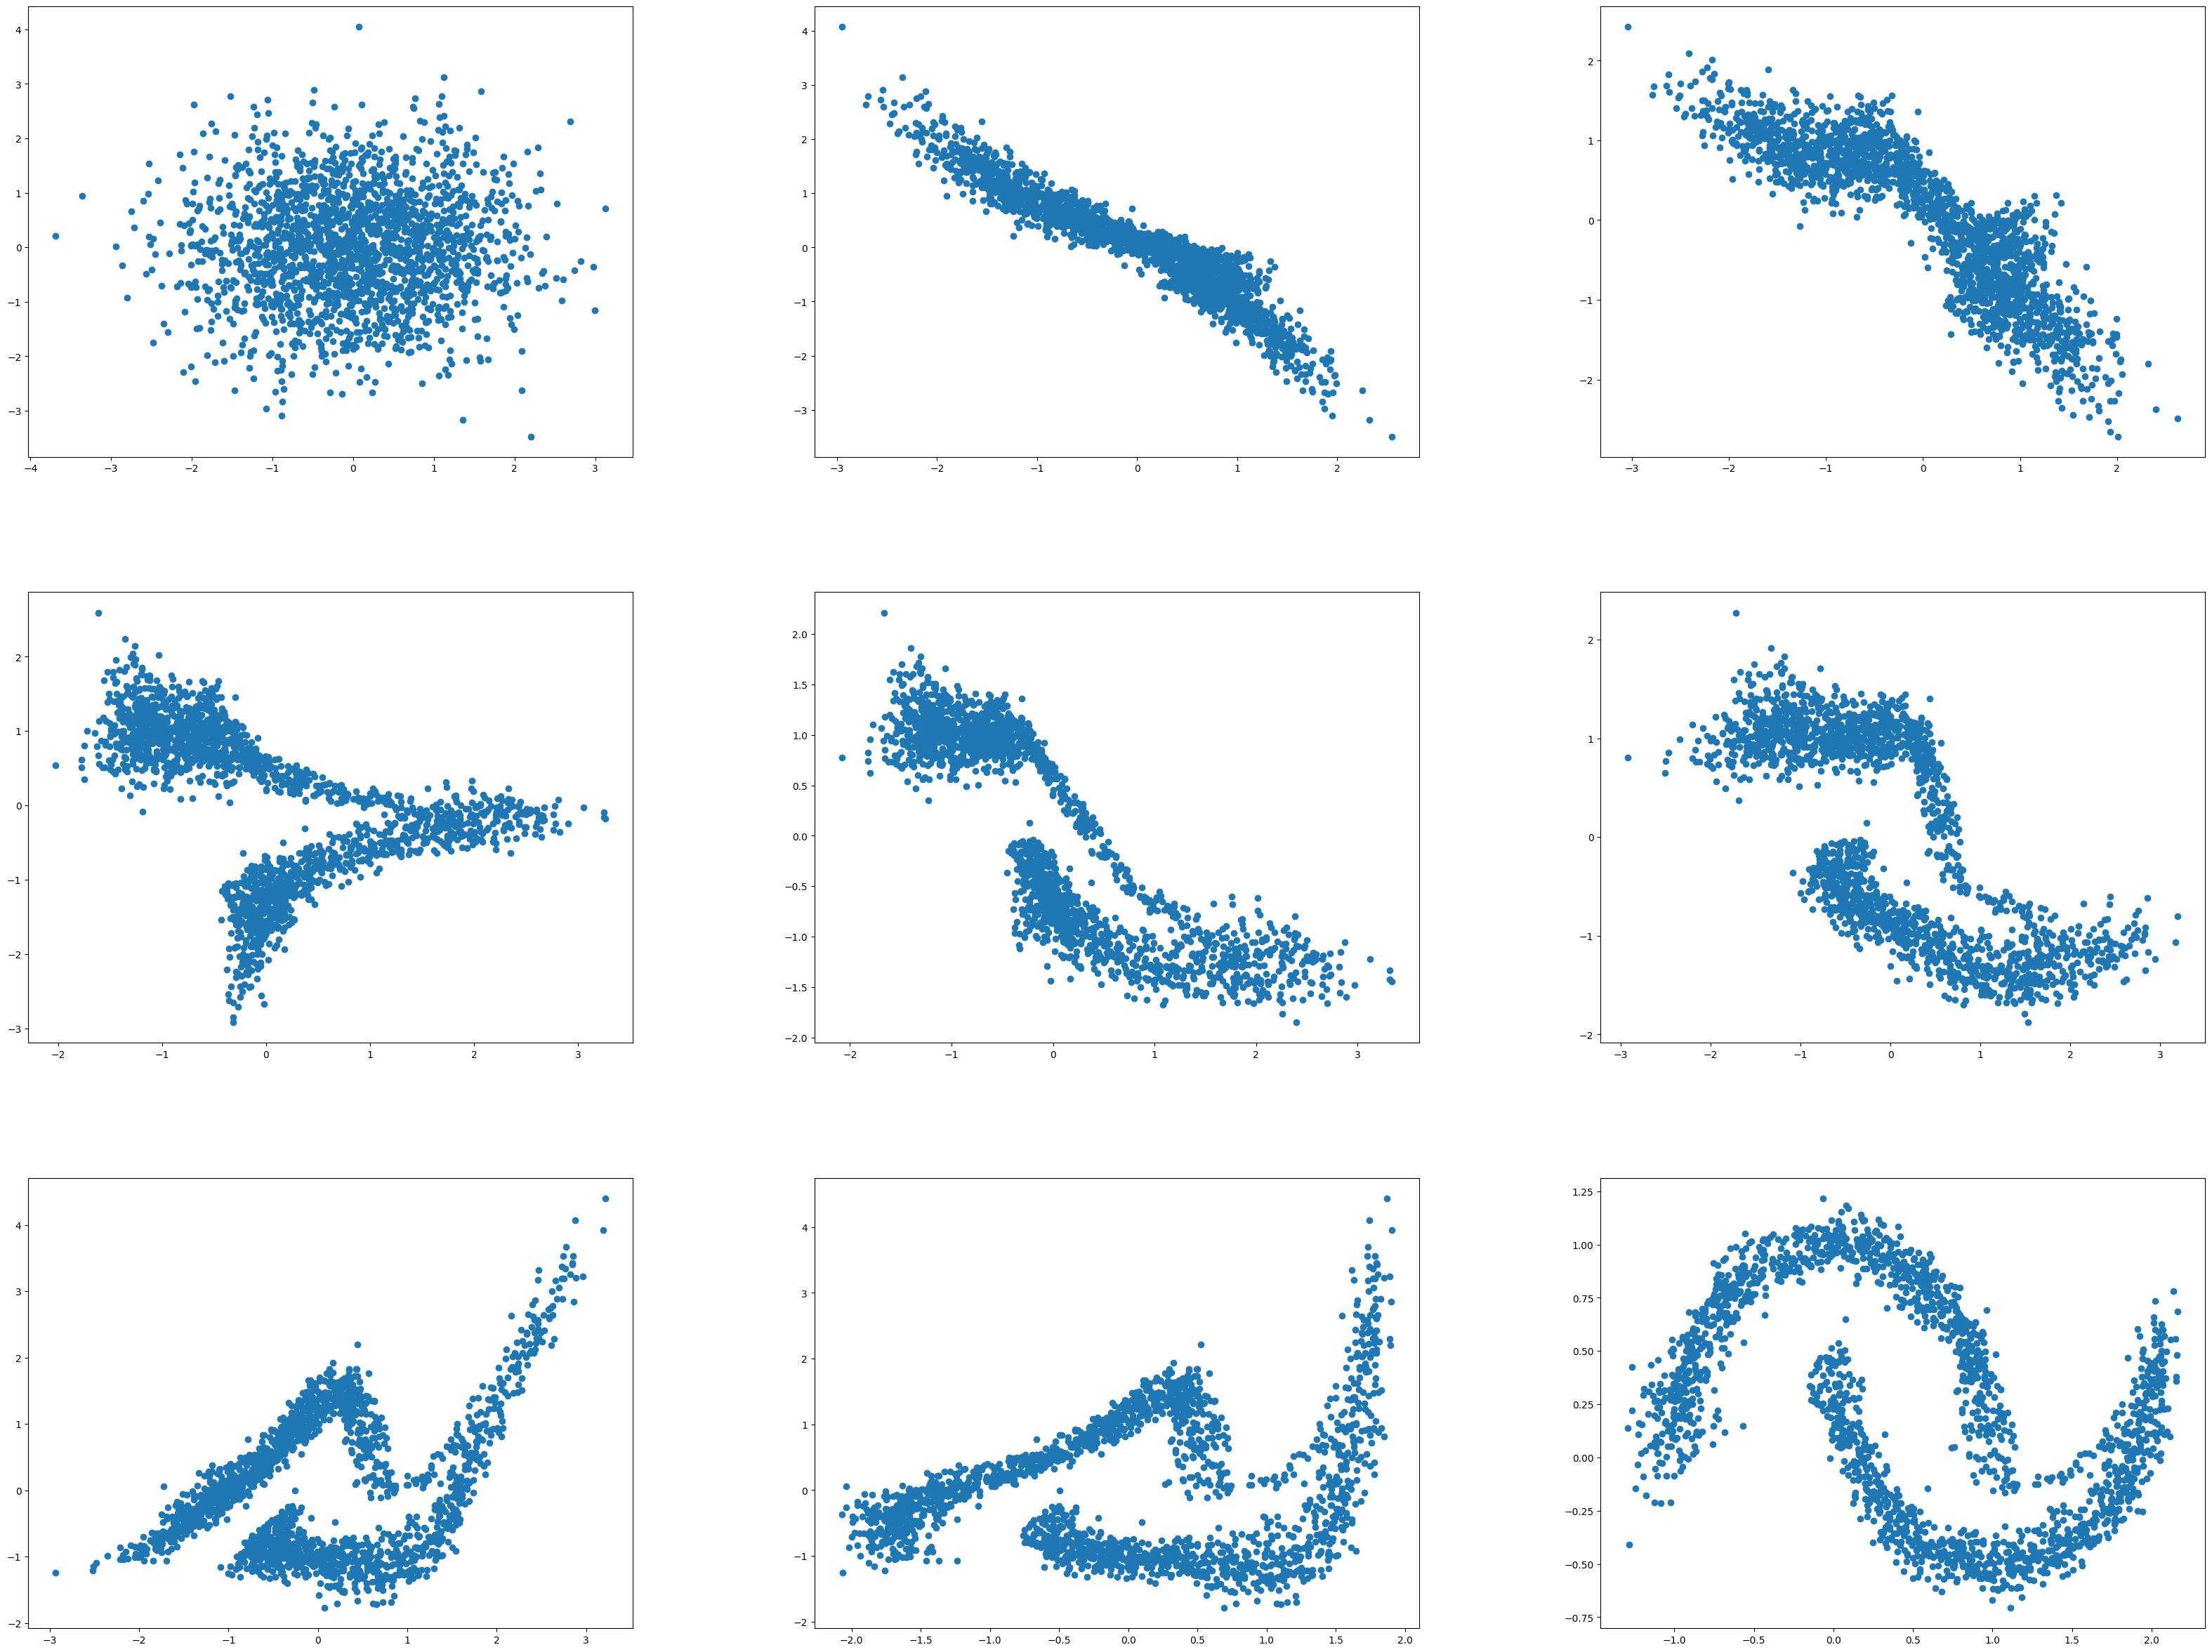

In [11]:
with torch.no_grad():
    f, axes = plt.subplots(3, 3)
    f.set_size_inches((40, 30))
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

    samples_per_layer = nf_model.inverse_per_layer(2000)

    for i in range(len(samples_per_layer)):
        z = samples_per_layer[i].cpu().numpy()
        axes[i//3, i%3].scatter(z[:,0], z[:,1])

    plt.show()

In [12]:
label_zero = np.empty((0,2))
label_one = np.empty((0,2))

for n, label in enumerate(test_labels):
    if label == 0:
        label_zero = np.append(label_zero, [test_data[n]], axis=0)
    else:
        label_one = np.append(label_one, [test_data[n]], axis=0)
        
label_zero = torch.Tensor(label_zero)
label_one = torch.Tensor(label_one)

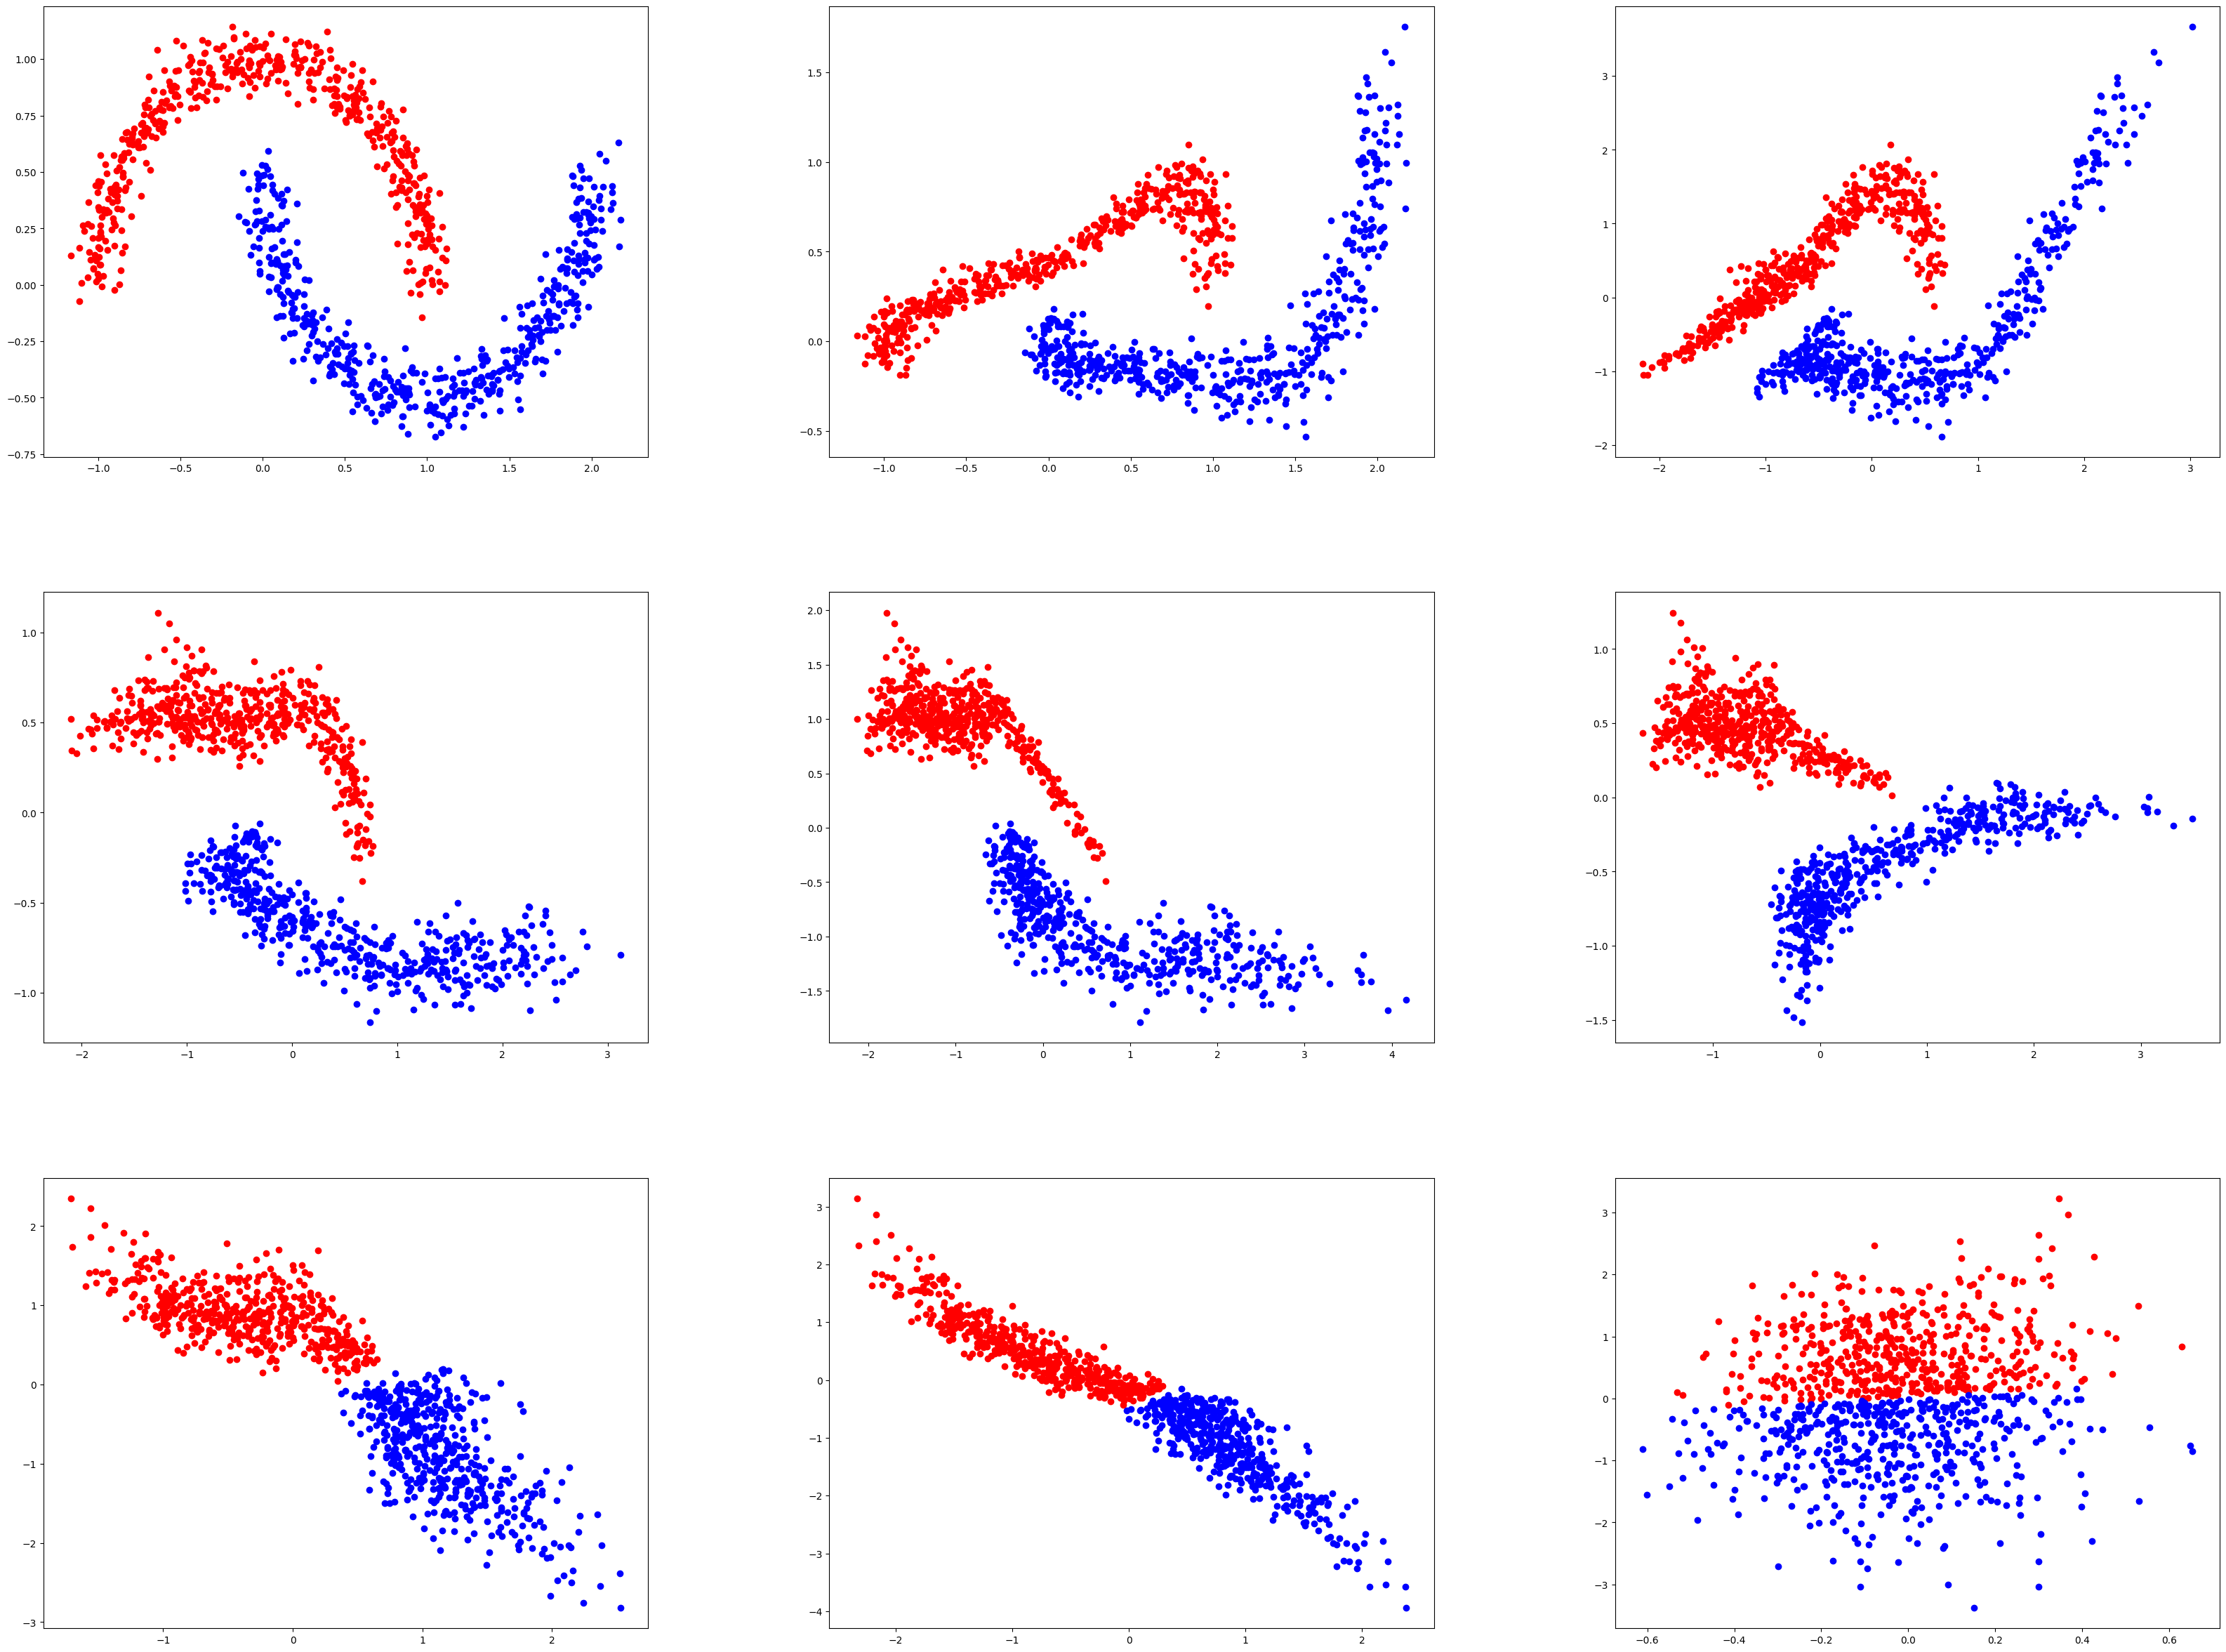

In [13]:
with torch.no_grad():
    f, axes = plt.subplots(3, 3)
    f.set_size_inches((40, 30))
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

    zero_per_layer = nf_model.forward_per_layer(label_zero)
    one_per_layer = nf_model.forward_per_layer(label_one)

    for i in range(len(zero_per_layer)):
        zero = zero_per_layer[i].cpu().numpy()
        one = one_per_layer[i].cpu().numpy()
        axes[i//3, i%3].scatter(zero[:,0], zero[:,1], color='red')
        axes[i//3, i%3].scatter(one[:,0], one[:,1], color='blue')

    plt.show()